In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Sequential API

In [31]:
model = keras.Sequential([    
    layers.Dense(64, activation="relu"), 
    layers.Dense(10, activation="softmax") 
])

# 또는
model = keras.Sequential()
model.add(layers.Dense(64, activation="relu")) 
model.add(layers.Dense(10, activation="softmax"))


# build를 통해 input size를 지정한다.
model.build((None, 3))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 64)                256       
_________________________________________________________________
dense_47 (Dense)             (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


In [32]:
# input을 같이 지정
model = keras.Sequential()
model.add(keras.Input(shape=(3,)))
model.add(layers.Dense(64, activation="relu"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 64)                256       
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


## 함수형 API

### 단일 입력

In [4]:
inputs = keras.Input(shape=(3,), name="my_input") # symbolic tensor
features = layers.Dense(64, activation="relu")(inputs)
outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_input (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


### 다중 입력, 다중 출력

In [5]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

# 3 inputs
title = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")

# hidden
features = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(64, activation="relu")(features)

# 2 outputs
priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(num_departments, activation="softmax", name="department")(features)

model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, 10000)]      0                                            
__________________________________________________________________________________________________
text_body (InputLayer)          [(None, 10000)]      0                                            
__________________________________________________________________________________________________
tags (InputLayer)               [(None, 100)]        0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 20100)        0           title[0][0]                      
                                                                 text_body[0][0]            

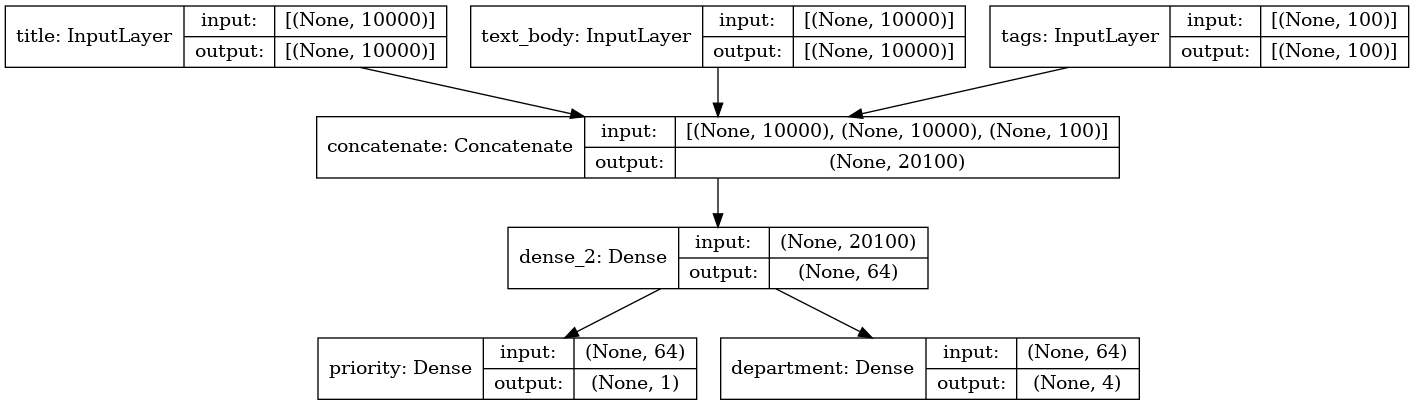

In [10]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

In [8]:
# 훈련
import numpy as np

# prepare dataset
num_samples = 1280

title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags)) 

priority_data = np.random.random(size=(num_samples, 1)) 
department_data = np.random.randint(0, 2, size=(num_samples, num_departments)) 

# train model
model.compile(optimizer="rmsprop",
              loss={
                  "priority": "mean_squared_error",
                  "department": "categorical_crossentropy",
              },
              metrics={
                  "priority": ["mean_absolute_error"],
                  "department": ["accuracy"],
              })

model.fit([title_data, text_body_data, tags_data],
          [priority_data, department_data],          
          epochs=1)

# evaluate
model.evaluate([title_data, text_body_data, tags_data],               
               [priority_data, department_data])
priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

40/40 [==============================] - 1s 9ms/step - loss: 18.8749 - priority_loss: 0.3351 - department_loss: 18.5398 - priority_mean_absolute_error: 0.5005 - department_accuracy: 0.2422


In [9]:
# 훈련
import numpy as np

# prepare dataset
num_samples = 1280

title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags)) 

priority_data = np.random.random(size=(num_samples, 1)) 
department_data = np.random.randint(0, 2, size=(num_samples, num_departments)) 

# train model
model.compile(optimizer="rmsprop",
              loss={
                  "priority": "mean_squared_error",
                  "department": "categorical_crossentropy",
              },
              metrics={
                  "priority": ["mean_absolute_error"],
                  "department": ["accuracy"],
              })

model.fit({"title": title_data,
           "text_body": text_body_data,
           "tags": tags_data},
          {"priority": priority_data,
           "department": department_data},
          epochs=1)

# evaluate
model.evaluate({"title": title_data,
                "text_body": text_body_data,
                "tags": tags_data},
               {"priority": priority_data,
                "department": department_data})
priority_preds, department_preds = model.predict({"title": title_data,
                                                  "text_body": text_body_data,
                                                  "tags": tags_data})

40/40 [==============================] - 1s 8ms/step - loss: 16.9903 - priority_loss: 0.3334 - department_loss: 16.6569 - priority_mean_absolute_error: 0.5002 - department_accuracy: 0.0492


### 새로운 출력 추가

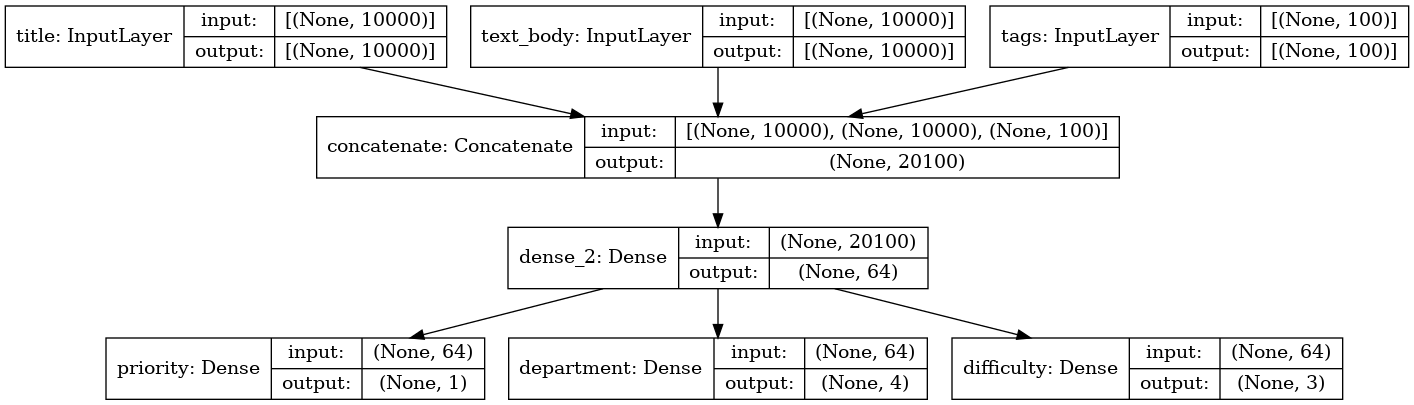

In [12]:
features = model.layers[4].output # 마지막 hidden layer의 출력
difficulty = layers.Dense(3, activation="softmax", name="difficulty")(features)

new_model = keras.Model(inputs=[title, text_body, tags],
                        outputs=[priority, department, difficulty])

plot_model(new_model, show_shapes=True)

## Subclassing

In [13]:
class CustomerTicketModel(keras.Model):     
    def __init__(self, num_departments):        
        super().__init__() 
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation="relu")          
        self.priority_scorer = layers.Dense(1, activation="sigmoid")         
        self.department_classifier = layers.Dense(num_departments, activation="softmax")     
        
    def call(self, inputs): 
        title = inputs["title"]
        text_body = inputs["text_body"]
        tags = inputs["tags"]
        
        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)         
        return priority, department

In [23]:
model = CustomerTicketModel(num_departments=4)


model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])

# model.summary() # 오류가 남

model.fit({"title": title_data,
           "text_body": text_body_data,
           "tags": tags_data},
          [priority_data, department_data],
          epochs=1)

model.summary()

40/40 [==============================] - 2s 27ms/step - loss: 42.7202 - output_1_loss: 0.3296 - output_2_loss: 42.3906 - output_1_mean_absolute_error: 0.4964 - output_2_accuracy: 0.2117
Model: "customer_ticket_model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
concatenate_9 (Concatenate)  multiple                  0         
_________________________________________________________________
dense_27 (Dense)             multiple                  1286464   
_________________________________________________________________
dense_28 (Dense)             multiple                  65        
_________________________________________________________________
dense_29 (Dense)             multiple                  260       
Total params: 1,286,789
Trainable params: 1,286,789
Non-trainable params: 0
_________________________________________________________________


## 혼합

In [27]:
class Classifier(keras.Model):
    def __init__(self, num_classes=2):
        super().__init__()
        
        if num_classes == 2:
            num_units = 1
            activation = "sigmoid"
        else:
            num_units = num_classes     
            activation = "softmax"
        
        self.dense = layers.Dense(num_units, activation=activation)
    
    def call(self, inputs):
        return self.dense(inputs)
    
inputs = keras.Input(shape=(3,))
features = layers.Dense(64, activation="relu")(inputs)
outputs = Classifier(num_classes=10)(features) # classifier에 대해서는 Subclasing model을 사용
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_36 (Dense)             (None, 64)                256       
_________________________________________________________________
classifier_3 (Classifier)    (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


In [29]:
inputs = keras.Input(shape=(64,))
outputs = layers.Dense(1, activation="sigmoid")(inputs)
binary_classifier = keras.Model(inputs=inputs, outputs=outputs)

class MyModel(keras.Model): 
    def __init__(self, num_classes=2):
        super().__init__()
        
        self.dense = layers.Dense(64, activation="relu") 
        self.classifier = binary_classifier # classifier에 대해서는 functional model 사용
    
    def call(self, inputs):        
        features = self.dense(inputs)
        return self.classifier(features)           
    
model = MyModel()

---

## 사용자 정의 훈련, 평가 루프

In [72]:
def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)    
    features = layers.Dropout(0.5)(features)   
    outputs = layers.Dense(10, activation="softmax")(features)    
    model = keras.Model(inputs, outputs)    
    return model

(images, labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255 
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

In [73]:
# fit
model = get_mnist_model()

loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.RMSprop()
metrics = [keras.metrics.SparseCategoricalAccuracy()]
loss_tracking_metric = keras.metrics.Mean()

@tf.function
def train_step(inputs, targets):    
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights)) 
    
    logs = {}
    
    for metric in metrics: 
        metric.update_state(targets, predictions)
        logs[metric.name] = metric.result() 
    
    loss_tracking_metric.update_state(loss)
    logs["loss"] = loss_tracking_metric.result()
    return logs

# 매 train 마다 
def reset_metrics():
    for metric in metrics:
        metric.reset_state()
    
    loss_tracking_metric.reset_state()
    

In [75]:
training_dataset = (tf.data.Dataset
                    .from_tensor_slices((train_images, train_labels))
                    .batch(32))
epochs = 3

for epoch in range(1, epochs+1):
    reset_metrics()

    for inputs_batch, targets_batch in training_dataset:        
        logs = train_step(inputs_batch, targets_batch)   

    print(f"{epoch}번째 에포크 결과")    

    for key, value in logs.items():
        print(f"...{key}: {value:.4f}")

1번째 에포크 결과
...sparse_categorical_accuracy: 0.9682
...loss: 0.1238
2번째 에포크 결과
...sparse_categorical_accuracy: 0.9704
...loss: 0.1182
3번째 에포크 결과
...sparse_categorical_accuracy: 0.9725
...loss: 0.1123


In [78]:
# evaluate
def test_step(inputs, targets):
    predictions = model(inputs, training=False) # training=False를 전달합니다.    
    loss = loss_fn(targets, predictions)
    logs = {}    
    
    for metric in metrics:        
        metric.update_state(targets, predictions) 
        logs["val_" + metric.name] = metric.result()
    
    loss_tracking_metric.update_state(loss)   
    logs["val_loss"] = loss_tracking_metric.result()    
    return logs      

val_dataset = (tf.data.Dataset
               .from_tensor_slices((val_images, val_labels))
              .batch(32))
reset_metrics() 

for inputs_batch, targets_batch in val_dataset:   
    logs = test_step(inputs_batch, targets_batch) 

print("평가 결과:") 

for key, value in logs.items():       
    print(f"...{key}: {value:.4f}")

평가 결과:
...val_sparse_categorical_accuracy: 0.9722
...val_loss: 0.1282


---

## 회고

- Keras로 모델을 생성하는 다양한 사용법을 알았고, 특히 subclassing 방식을 사용하여야하는 케이스를 알 수 있게된 것이 좋았습니다.
- 과정이 진행되면서 다양한 형태의 모델을 다룰텐데 오늘 내용이 큰 도움이 될 것 같습니다.

- 또한 실험을 하는 과정에서 모델을 구성할 때 어떻게 하면 좋을지 결과는 왜 그렇게 나오는지를 고민할 수 있어서 좋았습니다.